## Task 2 

In [2]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os
from shapely.validation import make_valid
from shapely.ops import unary_union


In [3]:
clip_dir = "C:/Users/cauba/OneDrive/Desktop/Case Study/CLIP"

adm4_ncr = gpd.read_file(f"{clip_dir}/adm4_ncr.shp")
flood_ncr = gpd.read_file(f"{clip_dir}/flood_ncr.shp")
health_ncr = gpd.read_file(f"{clip_dir}/health_ncr.shp")

road_layers_ncr = {}
for file in os.listdir(clip_dir):
    if file.startswith("road_") and file.endswith(".shp"):
        key = file.replace(".shp","")
        road_layers_ncr[key] = gpd.read_file(os.path.join(clip_dir, file))



In [4]:
print (flood_ncr)

   Var  AREA_KM2                                           geometry
0  3.0  40.89762  MULTIPOLYGON (((121.04158 14.78324, 121.04158 ...
1  1.0  62.58036  MULTIPOLYGON (((121.03702 14.78428, 121.03702 ...
2  2.0  92.03140  MULTIPOLYGON (((121.03637 14.78428, 121.03646 ...
3  0.0   0.00000  MULTIPOLYGON (((121.04077 14.37778, 121.04077 ...


In [5]:
proj_crs = "EPSG:32651"  # WGS 84 / UTM Zone 51N

adm4_ncr = adm4_ncr.to_crs(proj_crs)
flood_ncr = flood_ncr.to_crs(proj_crs)
health_ncr = health_ncr.to_crs(proj_crs)

for key, gdf in road_layers_ncr.items():
    road_layers_ncr[key] = gdf.to_crs(proj_crs)

In [6]:
# Print all CRS
print(f"ADM4 CRS: {adm4_ncr.crs}")
print(f"Flood CRS: {flood_ncr.crs}")
print(f"Health CRS: {health_ncr.crs}")
for key, gdf in road_layers_ncr.items():
    print(f"Road/Building Layer: {key} CRS: {gdf.crs}")
    

ADM4 CRS: EPSG:32651
Flood CRS: EPSG:32651
Health CRS: EPSG:32651
Road/Building Layer: road_buildings_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_buildings_Polygon_ncr CRS: EPSG:32651
Road/Building Layer: road_natural_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_places_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_pofw_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_pois_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_railways_LineString_ncr CRS: EPSG:32651
Road/Building Layer: road_traffic_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_transport_Point_ncr CRS: EPSG:32651
Road/Building Layer: road_water_MultiPolygon_ncr CRS: EPSG:32651
Road/Building Layer: road_water_Polygon_ncr CRS: EPSG:32651


## Task 2 Delivery
- ### All clipped vector layers were reprojected to WGS 84 / UTM Zone 51N (EPSG:32651) to allow accurate distance and area calculations. This ensures flood buffers and barangay areas are correctly measured in meters. Geographic CRS (lat/lon) would distort these metrics, so a projected CRS was required.

## Task 3

In [7]:
# Check if buffering is needed

print(adm4_ncr.is_valid.all())
print(flood_ncr.is_valid.all())


True
True


In [8]:
# Simplify flood polygons to reduce vertices 
flood_simple = flood_ncr.copy()
flood_simple["geometry"] = flood_simple.geometry.simplify(tolerance=5)  # 5 meters tolerance

In [9]:
flood_buffer = flood_simple.copy()
flood_buffer["geometry"] = flood_buffer.geometry.buffer(100)

In [10]:
flood_buffer_dissolved = flood_buffer.dissolve()
admin_dissolved = adm4_ncr.dissolve(by="ADM3_EN")


C:\Users\cauba\AppData\Local\Temp\ipykernel_4840\1007052766.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
C:\Users\cauba\AppData\Local\Temp\ipykernel_4840\1007052766.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


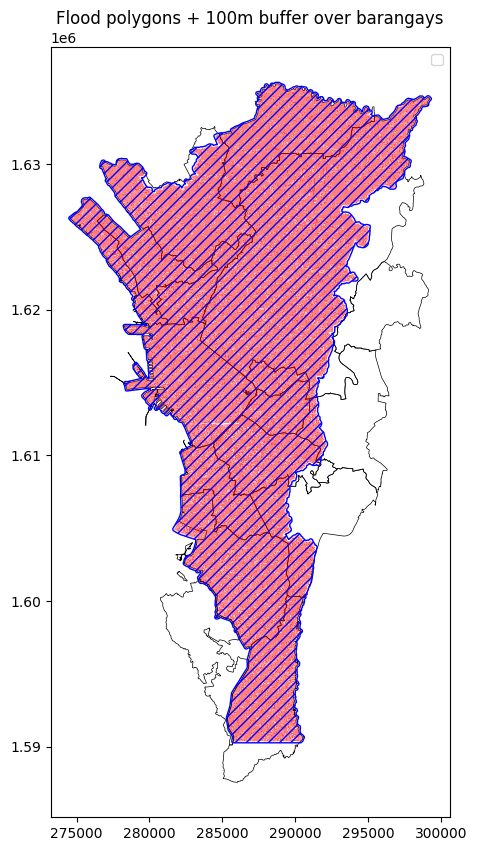

In [11]:
# --- 6. Plot ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
admin_dissolved.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, label="Municipalities")
flood_ncr.plot(ax=ax, color="red", alpha=0.5, label="Flood polygons")
flood_buffer_dissolved.plot(ax=ax, hatch="///", facecolor="none", edgecolor="blue", label="100m buffer")
plt.legend()
plt.title("Flood polygons + 100m buffer over barangays")
plt.show()

# save plot
fig.savefig("flood_buffer_plot.png", dpi=300)

## Task 4

In [37]:
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.ops import unary_union
from rasterstats import zonal_stats

In [46]:
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
from shapely.ops import unary_union

# ----------------------------
# 1. Open population raster
# ----------------------------
raster_path = "C:/Users/cauba/OneDrive/Desktop/Case Study/DATASETS/Population/phl_ppp_2020.tif"
raster = rasterio.open(raster_path)

# Copy of barangays to avoid overwriting
adm4_ncr_raster_crs = adm4_ncr.copy()

# Reproject barangays to raster CRS for zonal_stats
adm4_ncr_raster_crs = adm4_ncr_raster_crs.to_crs(raster.crs)

# ----------------------------
# 2. Clip raster to NCR boundary
# ----------------------------
ncr_geom = [feature["geometry"] for feature in adm4_ncr_raster_crs.__geo_interface__["features"]]
clipped_raster, clipped_transform = mask(raster, ncr_geom, crop=True)
clipped_raster_array = clipped_raster[0]
clipped_raster_array = np.where(clipped_raster_array < 0, 0, clipped_raster_array)  # fix nodata

# ----------------------------
# 3. Compute population per barangay
# ----------------------------
stats = zonal_stats(
    adm4_ncr_raster_crs,
    clipped_raster_array,
    affine=clipped_transform,
    stats=["sum"],
    all_touched=True,
    nodata=0
)
pop_stats = pd.DataFrame(stats)
adm4_ncr_raster_crs["Population"] = pop_stats["sum"].fillna(0)

# ----------------------------
# 4. Clip flood buffer to NCR boundary
# ----------------------------
proj_crs = "EPSG:32651"  # UTM Zone 51N
adm4_projected = adm4_ncr_raster_crs.to_crs(proj_crs)
flood_buffer_projected = flood_buffer_dissolved.to_crs(proj_crs)

# Dissolve NCR boundary
ncr_boundary = adm4_projected.dissolve()
ncr_geom_union = unary_union(ncr_boundary.geometry)

# Clip flood buffer to NCR
flood_buffer_projected_clipped = gpd.overlay(
    gpd.GeoDataFrame(geometry=[unary_union(flood_buffer_projected.geometry)], crs=proj_crs),
    gpd.GeoDataFrame(geometry=[ncr_geom_union], crs=proj_crs),
    how="intersection"
)

# ----------------------------
# 5. Compute % area in flood buffer
# ----------------------------
# Compute barangay area in meters
adm4_projected["barangay_area"] = adm4_projected.geometry.area

# Overlay with clipped flood buffer to get intersected area
intersect_buf = gpd.overlay(adm4_projected, flood_buffer_projected_clipped, how="intersection")
intersect_buf["int_area"] = intersect_buf.geometry.area

# Aggregate intersected area per barangay
area_per_barangay = intersect_buf.groupby("ADM4_EN")["int_area"].sum().reset_index()
area_per_barangay = area_per_barangay.rename(columns={"int_area": "int_area_buffer"})

# Merge back and fill missing values with 0
adm4_projected = adm4_projected.merge(area_per_barangay, on="ADM4_EN", how="left")
adm4_projected["int_area_buffer"] = adm4_projected["int_area_buffer"].fillna(0)

# Compute % area in buffer, capped at 100%
adm4_projected["%Area_in_Buffer"] = (
    (adm4_projected["int_area_buffer"] / adm4_projected["barangay_area"]) * 100
).clip(upper=100)

# ----------------------------
# 6. Compute people-in-hazard
# ----------------------------
adm4_projected["People_in_Hazard"] = (
    adm4_projected["Population"] * adm4_projected["%Area_in_Buffer"] / 100
)

# ----------------------------
# 7. Tag facilities by proximity class
# ----------------------------
facilities_projected = health_ncr.to_crs(proj_crs)

def proximity_class(fac_geom, buffer_geom, buffer_distance=100):
    if fac_geom.within(buffer_geom):
        return "Inside"
    elif fac_geom.distance(buffer_geom) <= buffer_distance:
        return f"≤{buffer_distance} m"
    else:
        return f">{buffer_distance} m"

facilities_projected["Proximity"] = facilities_projected.geometry.apply(
    lambda g: proximity_class(g, unary_union(flood_buffer_projected_clipped.geometry))
)

# ----------------------------
# 8. Top 10 barangays by people-in-hazard
# ----------------------------
top10 = adm4_projected[
    ["ADM4_EN", "ADM3_EN", "Population", "%Area_in_Buffer", "People_in_Hazard"]
].sort_values("People_in_Hazard", ascending=False).head(10)

# Round numbers for readability
top10["Population"] = top10["Population"].round(0).astype(int)
top10["People_in_Hazard"] = top10["People_in_Hazard"].round(0).astype(int)
top10["%Area_in_Buffer"] = top10["%Area_in_Buffer"].round(2)

# Rename columns
top10 = top10.rename(columns={
    "ADM4_EN": "Barangay",
    "ADM3_EN": "Municipality"
})

top10

# Save the table
top10.to_csv("top10_barangays_people_in_hazard.csv", index=False)


## Task 5

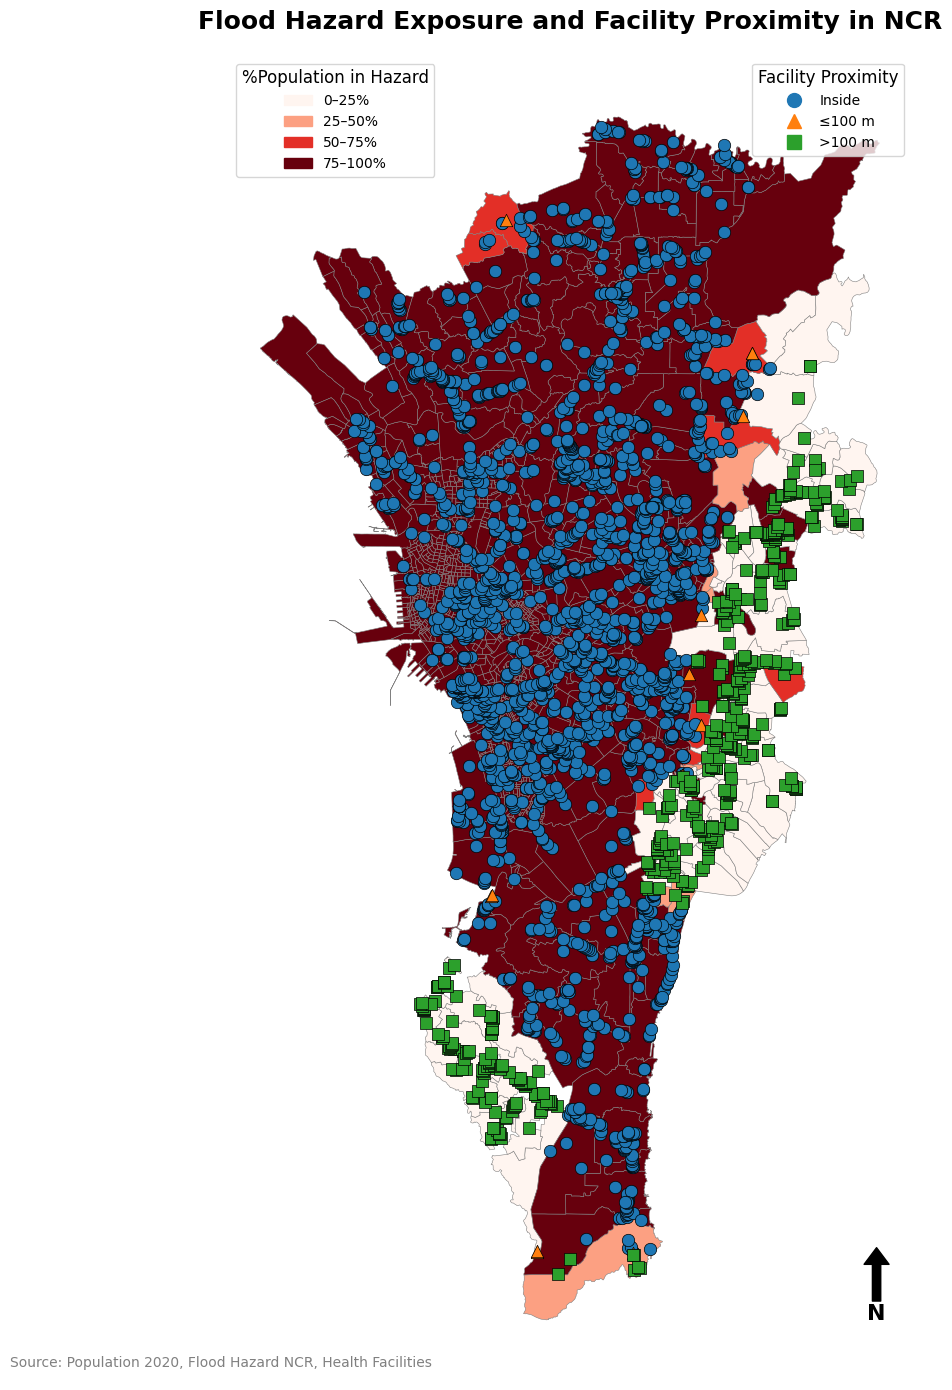

In [49]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from shapely.ops import unary_union

# ----------------------------
# 1. Choropleth classification (fixed bins)
# ----------------------------
bins = [0, 25, 50, 75, 100]  # %Area_in_Buffer bins
adm4_projected['hazard_class'] = pd.cut(
    adm4_projected['%Area_in_Buffer'],
    bins=bins,
    labels=False,
    include_lowest=True
)

# Define color map (light → dark red)
cmap = plt.cm.Reds
colors = [cmap(x / (len(bins)-2)) for x in range(len(bins)-1)]
adm4_projected['color'] = adm4_projected['hazard_class'].apply(lambda x: colors[int(x)] if pd.notna(x) else '#ffffff')

# ----------------------------
# 2. Plot map
# ----------------------------
fig, ax = plt.subplots(1, 1, figsize=(14, 14), facecolor='white')

# Plot barangays (choropleth)
adm4_projected.plot(
    ax=ax,
    color=adm4_projected['color'],
    edgecolor='gray',
    linewidth=0.4
)

# Overlay facilities with symbols for proximity
marker_dict = {
    'Inside': 'o',
    '≤100 m': '^',
    '>100 m': 's'
}

marker_colors = {
    'Inside': '#1f77b4',
    '≤100 m': '#ff7f0e',
    '>100 m': '#2ca02c'
}

for prox_class, marker in marker_dict.items():
    subset = facilities_projected[facilities_projected['Proximity'] == prox_class]
    subset.plot(
        ax=ax,
        marker=marker,
        markersize=80,
        label=prox_class,
        color=marker_colors[prox_class],
        edgecolor='black',
        linewidth=0.5
    )

# ----------------------------
# 3. Legends
# ----------------------------
# Hazard color patches
hazard_patches = [
    mpatches.Patch(color=colors[i], label=f'{bins[i]}–{bins[i+1]}%') for i in range(len(bins)-1)
]

# Facility markers
marker_lines = [
    mlines.Line2D([], [], color=marker_colors[label], marker=marker, linestyle='None', markersize=10, label=label)
    for label, marker in marker_dict.items()
]

# Add legends
first_legend = ax.legend(handles=hazard_patches, title='%Population in Hazard', loc='upper left', fontsize=10, title_fontsize=12)
ax.add_artist(first_legend)
ax.legend(handles=marker_lines, title='Facility Proximity', loc='upper right', fontsize=10, title_fontsize=12)

# ----------------------------
# 4. Map decorations
# ----------------------------
ax.set_title("Flood Hazard Exposure and Facility Proximity in NCR", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()

# North arrow
x, y, arrow_length = 0.95, 0.1, 0.05
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=6, headwidth=18),
            ha='center', va='center', fontsize=16, xycoords=ax.transAxes, fontweight='bold')

# Source
plt.figtext(0.1, 0.02, 'Source: Population 2020, Flood Hazard NCR, Health Facilities', fontsize=10, ha='left', color='gray')

# ----------------------------
# 5. Save map
# ----------------------------
plt.tight_layout()
plt.savefig("NCR_Flood_Hazard_Map.png", dpi=300, bbox_inches='tight')
plt.show()


In this study, the classification of the flood hazard choropleth was done using fixed intervals (0–25%, 25–50%, 50–75%, 75–100%) for the percentage of population exposed. This choice was made because the data is heavily skewed, with many barangays in Metro Manila showing full exposure (100%) due to the 100-year, 10-meter flood layer used. Methods like quantiles or Jenks natural breaks would have produced duplicate class edges or uneven groupings, making the map difficult to interpret and potentially introducing errors. Fixed intervals allow for consistent, easily interpretable categories that communicate hazard levels clearly to the audience.

Moreover, fixed intervals ensure that even in a dataset with extreme values and capped maximums, the choropleth map remains visually informative and publication-ready. While quantiles emphasize tails and Jenks highlights natural clusters, these methods are less effective when most observations fall into the highest category, as is the case here. By using fixed bins, we can clearly distinguish barangays with low, moderate, and high population exposure, and overlay facility proximity effectively, maintaining both clarity and accuracy in visual representation.